In [1]:
import numpy as np
from math import factorial, sqrt
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
plt.rc('font', family='Verdana')
from scipy.ndimage import zoom #делает скейл массива [0,1] -> [0, 0.5, 1] <- [0,1]
import random
import json
import sys, os
import time
import itertools
import requests
import threading
%matplotlib inline
plt.style.use('ggplot')  # Красивые графики
plt.rcParams['figure.figsize'] = (15, 5)  # Размер картинок

#соединяет все кардиограммы из папки в один массив
def merge_cardiograms(path:"string" = r"binary", amount:"int" = 0)->"":
    print("function 'put_together_cardiograms' in progress:")
    
    #создать список полных путей к каждой кардиограмме в папке
    names = os.listdir(path)
    files = [os.path.join(path, name) for name in names][:amount]
    global __cardiograms
    __cardiograms = np.zeros(0)
   
    def preparing(file:"list", name:"string"):
        print("preparing for {} in progress...".format(name))
        #считать с файла в numpy массив
        array = np.fromfile(file, dtype='i4', count=-1, sep='')
        #подменить "Nan" ноль
        array[np.isnan(array)] = 0   
        #нормализовать значения в пределах [-1,1]
        y = normalized(array)
        #удалить значения шума
        y = y[y!=   0.0]
        y = y[y!=-0.078]
        #threading.RLock().acquire()
        global __cardiograms
        __cardiograms = np.concatenate((__cardiograms, y), axis=0)
        #threading.RLock().release()

    for file, name in zip(files,names):
        threading.Thread(target=lambda: preparing(file, name), name= name).start()
 
    while threading.active_count() > 5:
        time.sleep(1)
    
    return __cardiograms


#нормализовать данные в пределах (-1,1) пиковое значение будет 1
def normalized(array):
    #константное число, тип чисел в массиве
    CONST_int32 = 2147483647
    return np.round(-(array / CONST_int32 * 0.99), decimals = 3)


#найти пики с условием поиска от начала пиков, возвращает пики, разметку values_x, values_y
def get_peaks(cardiogram:"list"= [], step:"int"= 185, frequency:'Hz'= 1) -> "вернет пики с позициями(идексами)":
    print("function 'get_peaks' in progress")
    x  = np.linspace(0, frequency*len(cardiogram), len(cardiogram), endpoint=False)
     
    index = 0
    values_x = []
    values_y = []
    
    while True:
        if len(cardiogram[index:index+step]) < step//5:
            break
        buffer = list(cardiogram[index:index+step])
        #находим максимум на отрезке
        y_max = max(buffer)
        #находим позицию максимума на отрезке
        x_position = index + buffer.index(y_max)
        #записываем максимум
        values_y += [y_max]
        #записываем позицию максимума
        values_x += [x[x_position]]
        #делаем отступ от стартового значения в половину шага
        index = x_position + step//2
        
    return values_x, values_y


#визуализация массива или несколько массивов
def render(*array:"lists of array", frequency:'Hz'= 1, colors=['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']):
    print("function 'render' in progress \n")
    #возвращает цвета из массива colors, когда кончатся стандартные цвета, будет генерировать случайные
    def get_color():
        for color in colors:
            yield color
    #экземпляр класса get_color
    color_buffer = get_color()

    for n, y in enumerate(array):
        #использует базовые цвета в наличии(colors), если заканчиваются, генерирует случайные
        if n < len(colors):
            color = next(color_buffer)        
        else:
            color = (np.random.randint(255, size=(1, 3))/255).flat

        x  = np.linspace(0, frequency*len(y), len(y), endpoint=False)
        plt.plot(x, y, color=color, marker ='')

    plt.show()

        
#посчитать коэффициент корреляции Пирсона между двумя значениями
def pearson_correlation(first, second) ->"вернет от -1 до 1, 1 - значит 100% сходство":
    #количество элементов массива
    array_len = len(first)

    #вычислить сумму значений массива
    first_sum  = sum(first)
    second_sum = sum(second)
       
    #вычислить сумму квадратов массива
    first_pow_sum  = sum([pow(i, 2) for i in  first])
    second_pow_sum = sum([pow(i, 2) for i in second])

    #вычислить сумму произведений 
    first_second_product_sum = sum([i[0]*i[1] for i in zip(first, second)])

    #вычислить коэффициент Пирсона
    num = first_second_product_sum - (first_sum * second_sum/array_len)
    den = sqrt((first_pow_sum - pow(first_sum, 2)/array_len)*(second_pow_sum - pow(second_sum, 2)/array_len))

    if den == 0: return 0

    correlation = num/den
    return correlation


#обрезать по пикам
def max_cutter(array:"list"= [], indent:"int" = 10) -> "вернет список обрезанный по пикам пределах":
    
    startMax = array.index(max(array[:indent]))
    #берет перевернутый список, так как по индексу возьмет первое число что попадется
    endMax   = array[::-1].index(max(array[-indent:]))
    if  endMax == 0:
        endMax = 1
    
    return array[startMax:-endMax]


#создает списки, где на каждой позиции массив с одним сокращением и его длиной, используй данные от "get_peaks" - array[0]
def separate_by_peak(offcuts:"list"= [], cardiogram:"list"= [], length:'const' = 200) -> "вернет словарь":
    print("function 'separate_by_peak' in progress")
    assert (type(length) == int), "(from separate_by_peak)size should be INT, but - {}".format(size)
    systoles = []
    lengths  = []
    for n,i in enumerate(offcuts[:-1]):

        startIndex = int(offcuts[n])
        endIndex   = int(offcuts[n + 1])
        
        #берет одно сокращение
        systole = list(cardiogram[startIndex:endIndex])
        #фильтрует(обрезает правильно) неправильно обрезанные пики, потенциально может попасть правильная аномалия(например жел. экстрасистола)
        systole_cuted = max_cutter(systole, indent=10)
        
   
            
        #считаем коэффициент скейла в процентах, на 100 не умножаем что бы получить коэффициент для умножения
        ratio = (length/len(systole_cuted))
        #втискиваем массив в 200 позиций

        systole_zoomed = zoom(systole_cuted, ratio).tolist()
        #алгоритм zoom ломает последнее значение, точнее назначает 0 на посленюю ячейку массива [1,1,1,1,1,0]
        #если поледнее значение равно - 0, берем предидущие и добавляем к нему среднее значене между 2мя предидущими 
        if  systole_zoomed[-1] == 0:
            systole_zoomed[-1] = systole_zoomed[-2] + sum(systole_zoomed[-3:-1])/2
    

        #добавляем сокращение в общий массив
        systoles.append(systole_zoomed)
        #добавляем коэффициент скейла сокращения
        lengths.append(ratio)
    
    #возвращает словарь сокращений и их размеры [[сокращения,..][коэффициенты скейла,..]]
    return {"systoles":systoles, "lengths":lengths}


#поделить все сокращения по типам используя коэффициент корреляции Пирсона
def separate_by_types(systoles:"lists of systoles" = [], lengths:"list" = []):
    print("function 'separate_by_types' in progress \n")
    #создаем словарь, в который будем добавлять ключ - тип, на каждый ключ стисок подобных сокрщений
    types = {} 
    
    #проходимся по общему списку запоминая позицию
    for name, first in enumerate(systoles):
        #проходимся по общему списку и параллельно по длинам сокращенийб начиная с 2го значения
        for second, length in zip(systoles[1:], lengths[1:]):
            
            #находим коэффициент подобия между первым и вторым, третим.., сокрщением
            sameness = pearson_correlation(first, second)
            #если коэффициент подобия больше чем 0.85
            if sameness > 0.88: # <------------------------------------------------------------------------- 0.88
                #создаем имена ключей для сокращений и длин
                systoles_type   = "type_{}".format(name)
                systoles_length = "length_{}".format(name)
                #если ключ типа не существует, создаем новый тип в словаре, создаем длины типов
                if systoles_type not in types:
                    types[systoles_type]  = []
                    types[systoles_length]= []
                #добавляем сокращение в словарь, ключ(name) с таким же типом 
                types[systoles_type]  += [second] 
                #добавляем длину сокращения
                types[systoles_length]+= [length]
                #удалить из списка сокращений которое добавили в словарь по типу
                systoles.remove(second)

    return types


#возвращает имя(ключ) из словаря по которому список с самым большим количеством элементов, 
#подразумевается что больше всего нормальных сокращений 
def sorted_systoles(arrays:"dict" = {}) -> "принимает словарь и возвращает список в котором первое значение - имя(ключ), второе - имя(ключ длин)":
    print("function 'sorted_systoles' in progress \n")
    assert(type(arrays)== dict), "from 'sorted_systoles' - you should use dict, not {}".format(type(arrays))

    systoles = []
    lengths  = []
    names    = []

    for name in arrays:
        if name.split("_")[0] == "type":
            systoles.append(arrays[name])
            names.append(name)

        elif name.split("_")[0] == "length":
            lengths.append( arrays[name])
        
        else:
            print("NAME: {} , it is look like bug!".format(name))
        
    return systoles, lengths, names

In [14]:
if __name__ == '__main__':
    #соединяем все кардиограммы вместе "amount =" - указывает количество выбранных кардиограмм
    y = merge_cardiograms(amount = 5)

    #найти пики с позициями по частоте array[0] - позиции "X", array[1] - значения R пиков "Y" 
    systoles_peak = get_peaks(cardiogram = y)

    #разбить массив на куски по сокращениям используя данные от "get_peaks" - array[0], сделать их одинаковыми размерами  
    cardiogram = separate_by_peak(offcuts = systoles_peak[0], cardiogram = y, length = 196)

    #возвращает словарь, на каждый тип свой ключ, по каждому ключу список сокращений одного типа 
    systoles_by_types = separate_by_types(systoles = cardiogram["systoles"], lengths = cardiogram["lengths"])  

    systoles, lengths, names = sorted_systoles(systoles_by_types)


    dict_data = {"systoles":[],"lengths" :[], "types":[]}
    for n, name in enumerate(names):
        for systole, length in zip(systoles[n], lengths[n]):
            dict_data["systoles"]+=[systole]
            dict_data["lengths"] +=[length]
            dict_data["types"]   +=[n]


    #создаем DataFrame с данными(сокрашение, длина, тип)
    df_data = pd.DataFrame(data= dict_data, columns=["systoles", "lengths", "types"])

    
    #df_data[df_data.groupby('types')['types'].transform('size') > 1]   
    #Для наглядности создаем колонку count и производим фильтрацию таблицы по ней
    df_data['count'] = df_data.groupby('types')['types'].transform('count')
    
    #фильтрация
    df_data= df_data.loc[df_data['count'] >1]
    
    #сбрасываем индексы
    df_data = df_data.reset_index()
    
    #запись в файл
    df_data.to_hdf("df_data.h5", 'key_to_store', table=True, mode='a')
    
    #информация
    df_data.info()
    print("df_data.h5 - saved")

function 'put_together_cardiograms' in progress:
preparing for 009cecedecb76a6ee2aec4e0b15445c2 in progress...
preparing for 065080e859f502797866dabaa7c22205 in progress...preparing for 0a32ddef33730bbe3d4693c143300029 in progress...preparing for 0d45540c8e1e6b5b7ffdbb8ddd36a13e in progress...


preparing for 0decb669f012fa436c2b1ef341e73474 in progress...
function 'get_peaks' in progress
function 'separate_by_peak' in progress


C:\Users\o.zaitsev\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


function 'separate_by_types' in progress 

function 'sorted_systoles' in progress 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2479 entries, 0 to 2478
Data columns (total 5 columns):
index       2479 non-null int64
systoles    2479 non-null object
lengths     2479 non-null float64
types       2479 non-null int64
count       2479 non-null int64
dtypes: float64(1), int64(3), object(1)
memory usage: 96.9+ KB
df_data.h5 - saved


C:\Users\o.zaitsev\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:1299: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['systoles']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


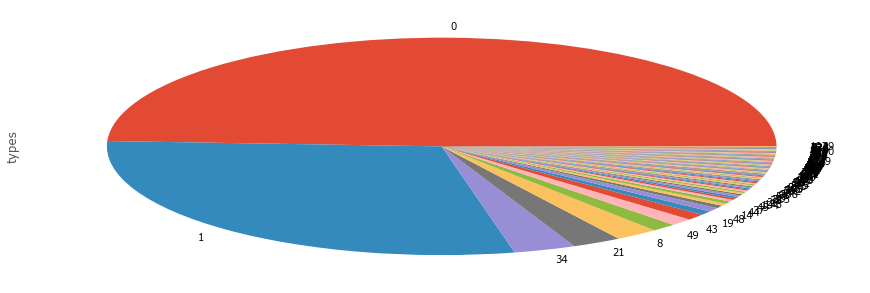

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df_data = pd.read_hdf('df_data.h5')

#df_data['types'].value_counts() #- узнать количество типов
#df_data['lengths'].mean() #- показать среднее значение
df_data['types'].value_counts().plot.pie() #- нарисовать диаграмму